In [24]:
import sys

sys.path.append("../") 

import os
import glob
from utils.reference_fronts import ReferenceFronts
from utils.file_utils import parse_exp_log_dir, load_n_evaluation_log, parse_meta
from utils.performance_evaluator import PerformanceEvaluator
import pandas as pd

search_dir = "../data"
exp_dir_pattern = "N-obj"

subdirs = [os.path.join(search_dir,d) for d in os.listdir(search_dir) if os.path.isdir(os.path.join(search_dir, d)) and d.startswith(exp_dir_pattern)]

meta_list = []
for subdir in subdirs:
    meta_list += (parse_meta(exp_dir=subdir))
    
exp_df = pd.DataFrame(meta_list)

In [25]:
def parse_result_file(exp_file_path:str):
    result_df = pd.read_csv(exp_file_path)
    return result_df

In [51]:
dimension = 2
n_objectives = 5
solvers = ["MOEAD","NSGAII","GDE3","OMOPSO","IBEA"]
tree = "depth.json"
naming_prefix = f"dim{dimension}_objs{n_objectives}_tree_{tree.split('.')[0]}"

stat_res = []
for solver in solvers:
    filtered_df = exp_df[(exp_df["dimension"] == dimension) & (exp_df["n_objectives"]==n_objectives) & (exp_df["solver"]==solver) & (exp_df["tree"]==tree)]
    for i, row in filtered_df.iterrows():
        eval_info = parse_result_file(row["exp_result_file"])
        try:
            vc = eval_info["eval_node_id"][99900:].value_counts()
            stat_res.append(
                {   
                    "solver":solver,
                    "exp_index":i,
                    "root":vc.get(0,0),
                    "node_1":vc.get(1,0),
                    "node_2":vc.get(2,0),
                    "node_3":vc.get(3,0),
                    "node_4":vc.get(4,0),
                    "node_5":vc.get(5,0)
                }
            )
        except Exception as e:
            continue

In [52]:
stat_res = pd.DataFrame(stat_res)
stat_res.to_csv(naming_prefix+".csv")

In [53]:
stat_res

,solver,exp_index,root,node_1,node_2,node_3,node_4,node_5
0,NSGAII,34826,99,1,0,0,0,0
1,NSGAII,34827,100,0,0,0,0,0
2,NSGAII,34828,94,5,1,0,0,0
3,NSGAII,34829,93,5,2,0,0,0
4,NSGAII,34830,96,4,0,0,0,0
...,...,...,...,...,...,...,...,...
835,IBEA,27688,79,4,9,4,4,0
836,IBEA,27689,80,9,8,0,3,0
837,IBEA,27690,86,5,5,2,2,0
838,IBEA,27691,88,8,3,1,0,0


In [54]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import ptitprince as pt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_identifier = "100_exps"
df = pd.read_csv(naming_prefix+".csv").fillna(0)

for solver, sub_df in df.groupby("solver"):
    print(solver, sub_df[["root", "node_1", "node_2", "node_3", "node_4" ]].mean())

GDE3 root      98.514286
node_1     1.428571
node_2     0.052381
node_3     0.004762
node_4     0.000000
dtype: float64
IBEA root      80.300000
node_1     9.342857
node_2     5.276190
node_3     2.742857
node_4     2.338095
dtype: float64
NSGAII root      98.504762
node_1     1.357143
node_2     0.128571
node_3     0.009524
node_4     0.000000
dtype: float64
OMOPSO root      0.0
node_1    0.0
node_2    0.0
node_3    0.0
node_4    0.0
dtype: float64


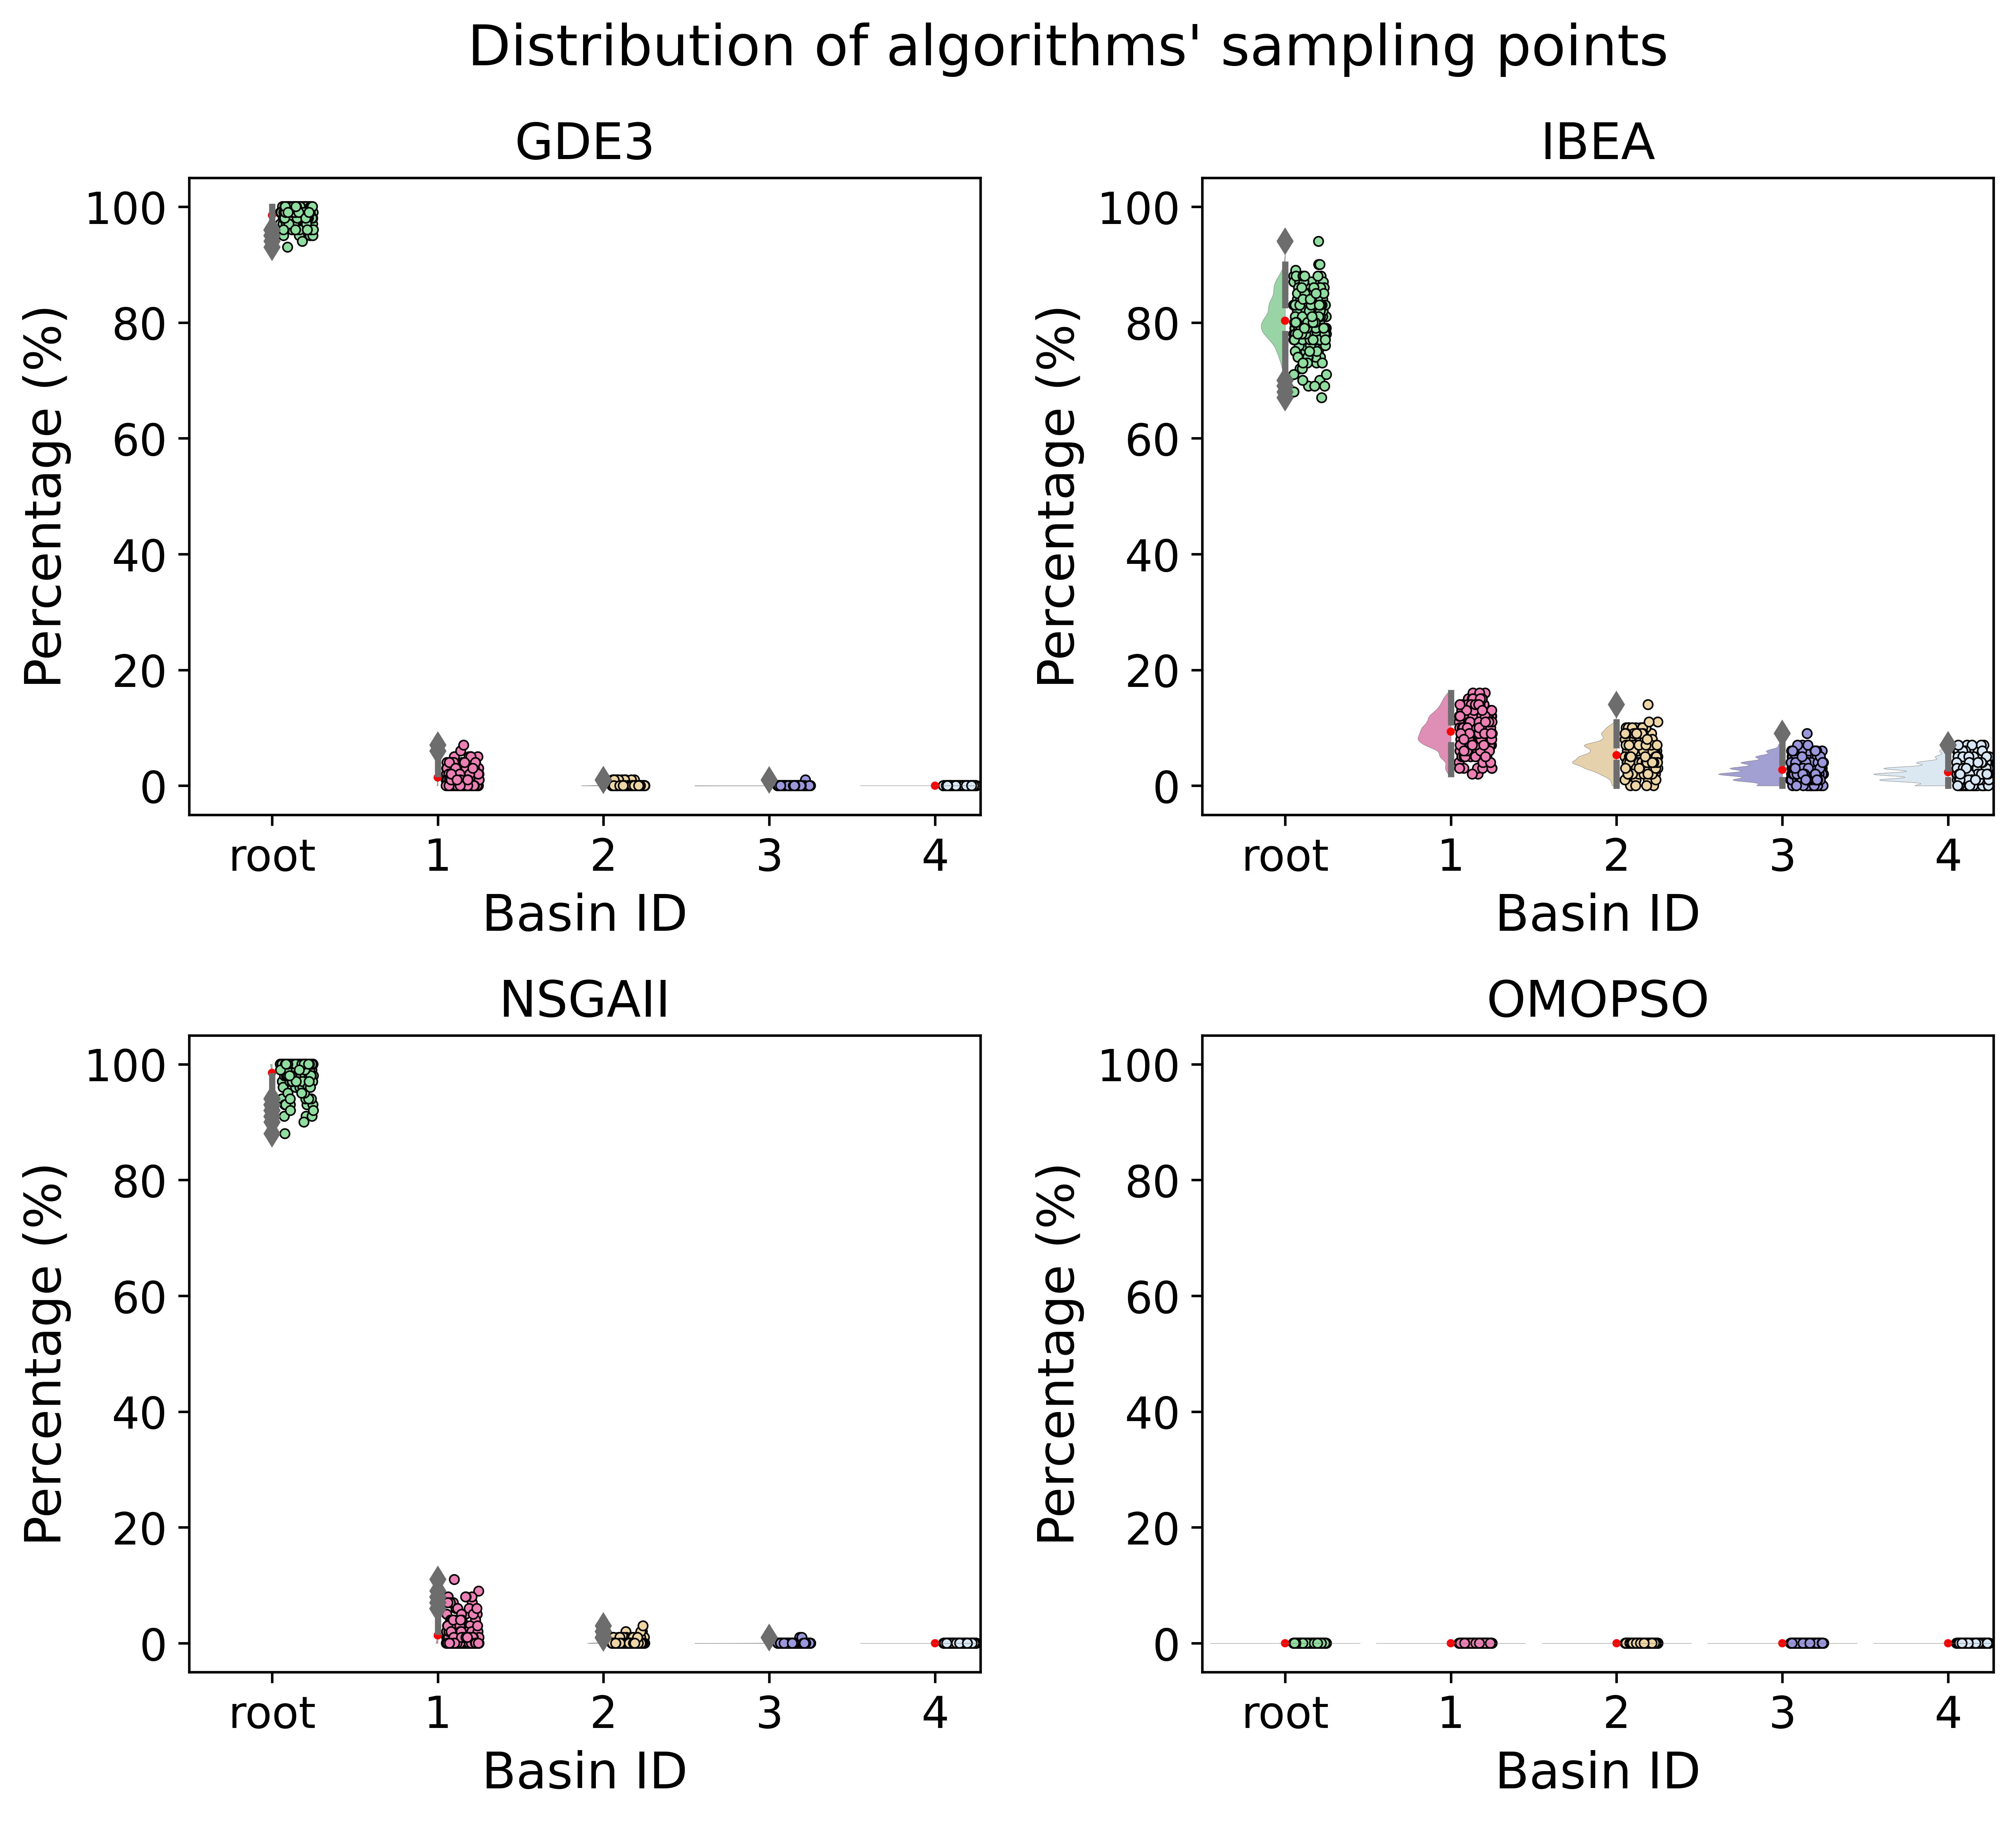

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(9, 8),dpi=600)
fig.suptitle("Distribution of algorithms' sampling points",fontsize=18)
fig.tight_layout(pad=2,w_pad=4,h_pad=5)
width = 0.6
colors = ["#8fdea0","#ec80b4", "#eed5a4","#9a97dc","#d7e7f5"]
palette = sns.color_palette(colors)

index = 0
for solver, sub_df in df.groupby("solver"):
    sub_results = []
    for sub_index, row in sub_df.iterrows():
        sub_results.append({"node_name": "root", "percentage": row["root"]})
        sub_results.append({"node_name": "1", "percentage": row["node_1"]})
        sub_results.append({"node_name": "2", "percentage": row["node_2"]})
        sub_results.append({"node_name": "3", "percentage": row["node_3"]})
        sub_results.append({"node_name": "4", "percentage": row["node_4"]})
    sub_results = pd.DataFrame(sub_results)
    if solver == "MOEAD":
        solver = "MOEA/D"
    if solver == "NSGA":
        solver = "NSGA-II"
    solver_name = solver
    plot_row = index // 2
    plot_col = index % 2
    plt.subplot(2,2,index+1)
    plt.title(solver_name, fontsize=16)
    # pt.RainCloud(x="day", y="total_bill", data=tips, orient="v")
    # axs[plot_row,plot_col].set_xlabel("Basin name")
    # axs[plot_row,plot_col].set_ylabel("Percentage of solver instances")
    # axs[plot_row,plot_col].set_ylim([-5, 105])

    plt.ylim([-5,105])
    # plt.grid(visible=False)
    pt.RainCloud(data=sub_results, x="node_name", y="percentage", orient="v", width_viol=0.9,linewidth=0.1,point_size=3,
             rain_edgecolor='black', rain_linewidth=0.5, rain_alpha=1,move = 0.15,width_box=0,box_linewidth=0,offset=-0.0,pointplot=True, point_linestyles='', point_scale=0.3, palette=palette)
    plt.xlabel("Basin ID", fontsize=16)
    plt.ylabel("Percentage (%)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    index += 1
    # axs[plot_row,plot_col].set_xticks([1, 2, 3, 4, 5], ["root","node_1","node_2","node_3","node_4"])
    # axs[plot_row,plot_col].set_xticklabels(["root","node_1","node_2","node_3","node_4"], fontdict=None, minor=False)
plt.savefig(f"rainplot_{naming_prefix}_{file_identifier}.png")
plt.savefig(f"rainplot_{naming_prefix}_{file_identifier}.pdf", format="pdf", bbox_inches="tight")